In [1]:
import mne
import nibabel as nib
from skimage import io
from matplotlib import pyplot as plt
from scipy import signal, stats

import numpy as np
import os

from IPython.display import clear_output
%matplotlib inline

In [2]:
!ls ./reports/low_net3D_1_all/

32  35	36  37	38  39	40  41	42  43	44  45	46  47	48  49	50


In [3]:
checkpoint_name = './reports/low_net3D_1_all/'

In [4]:
def get_stats(man):
    base_results = np.load('{}/{}/base_losses.npy'.format(checkpoint_name, man))
    net_results = np.load('{}/{}/net_losses.npy'.format(checkpoint_name, man))
    frame_index_list = np.load('{}/{}/frame_index_list.npy'.format(checkpoint_name, man))
    slice_index_list = np.load('{}/{}/slice_index_list.npy'.format(checkpoint_name, man))
    total_sum_of_squares = np.load('{}/{}/base_test_mean_losses.npy'.format(checkpoint_name, man))
    residual_loss_list = np.load('{}/{}/residual_loss_list.npy'.format(checkpoint_name, man))
    
    net_predictions = np.load('{}/{}/net_predictions.npy'.format(checkpoint_name, man))
    gt_predictions = np.load('{}/{}/gt_predictions.npy'.format(checkpoint_name, man))
    
    
    base_loss = np.sum(base_results)
    net_loss = np.sum(net_results)
    r2 = 1 - net_loss/base_loss
    
    slice_losses = np.zeros([30, 64, 64])
    slice_base_losses = np.zeros([30, 64, 64])
    slice_total_squares = np.zeros([30, 64, 64])
    residual_loss_num = np.zeros([30, 64, 64])
    residual_loss_denum = np.zeros([30, 64, 64])
    for i, slice_indx in enumerate(slice_index_list):
        slice_losses[slice_indx] += net_results[i] 
        slice_base_losses[slice_indx] += base_results[i]
        slice_total_squares[slice_indx] += total_sum_of_squares[i]
        residual_loss_num[slice_indx] += (net_predictions[i] - gt_predictions[i])**2
        residual_loss_denum[slice_indx] += (gt_predictions[i])**2

    for i in range(30):
        slice_losses[i] /= np.sum(slice_index_list == i)
        slice_base_losses[i] /= np.sum(slice_index_list == i)
        slice_total_squares[i] /= np.sum(slice_index_list == i)
    residual_loss = np.sqrt(residual_loss_num/(residual_loss_denum + 1e-9))
    return r2, slice_losses, slice_base_losses, slice_total_squares, residual_loss

def get_voxel_predictions(man, slice, indx1, indx2, slice_index_list=None, net_predictions=None, gt_predictions=None):
    if slice_index_list is None:
        slice_index_list = np.load('{}/{}/slice_index_list.npy'.format(checkpoint_name, man))
    if net_predictions is None:
        net_predictions = np.load('{}/{}/net_predictions.npy'.format(checkpoint_name, man))
    if gt_predictions is None:
        gt_predictions = np.load('{}/{}/gt_predictions.npy'.format(checkpoint_name, man))
    
    net_voxel_preds = []
    gt_voxel_preds = []
    for i in range(len(slice_index_list)):
        if slice_index_list[i] != slice:
            continue
        
        net_voxel_preds.append(net_predictions[i, indx1, indx2])
        gt_voxel_preds.append(gt_predictions[i, indx1, indx2])
        
    return net_voxel_preds, gt_voxel_preds

def get_correlations(man):
    slice_index_list = np.load('{}/{}/slice_index_list.npy'.format(checkpoint_name, man))
    net_predictions = np.load('{}/{}/net_predictions.npy'.format(checkpoint_name, man))
    gt_predictions = np.load('{}/{}/gt_predictions.npy'.format(checkpoint_name, man))
    
    result = np.zeros([30, 64, 64])
    for s in range(30):
        for i in range(64):
            for j in range(64):
                p, q = get_voxel_predictions(man, s, i, j, slice_index_list, net_predictions, gt_predictions)
                result[s, i, j], _ = stats.pearsonr(p, q)
    return result

def get_grad(man):
    return np.load('{}/{}/grad_statistic.npy'.format(checkpoint_name, man))[:, 0].mean(0)

In [5]:
def get_statistics_full(i):
    fmri_path = '../../data/fMRI/'
    fmri = read_img(os.path.join(fmri_path, str(all_people[i])))
    net_predictions = np.load('{}/{}/net_predictions.npy'.format(checkpoint_name, str(all_people[i])))
    gt_predictions = np.load('{}/{}/gt_predictions.npy'.format(checkpoint_name, str(all_people[i])))
    slice_index_list = np.load('{}/{}/slice_index_list.npy'.format(checkpoint_name, str(all_people[i])))
    fmri_mean = fmri.mean(-1) / 4095 * 100
    num = np.zeros([30, 64, 64])
    denum = np.zeros([30, 64, 64])

    for i, indx in enumerate(slice_index_list):
        mean = fmri_mean[..., indx]
        num[indx] += (net_predictions[i] - gt_predictions[i]) ** 2
        denum[indx] += (gt_predictions[i] - mean) ** 2
    stats = np.sqrt(num / (denum + 1e-9))
    return stats

In [6]:
def get_statistics_train(i):
    fmri_path = '../../data/fMRI/'
    fmri = read_img(os.path.join(fmri_path, str(all_people[i])))
    net_predictions = np.load('{}/{}/net_predictions.npy'.format(checkpoint_name, str(all_people[i])))
    gt_predictions = np.load('{}/{}/gt_predictions.npy'.format(checkpoint_name, str(all_people[i])))
    slice_index_list = np.load('{}/{}/slice_index_list.npy'.format(checkpoint_name, str(all_people[i])))
    fmri_mean = fmri[..., :210].mean(-1) / 4095 * 100
    num = np.zeros([30, 64, 64])
    denum = np.zeros([30, 64, 64])

    for i, indx in enumerate(slice_index_list):
        mean = fmri_mean[..., indx]
        num[indx] += (net_predictions[i] - gt_predictions[i]) ** 2
        denum[indx] += (gt_predictions[i] - mean) ** 2
    stats = np.sqrt(num / (denum + 1e-9))
    return stats

In [7]:
def read_img(path):
    path = path[:-7]
    files = os.listdir(path)
    for file in files:
        if file[-12:] == 'cross.nii.gz':
            return nib.load(os.path.join(path, file)).get_data()

In [8]:
fmri_path = '../../data/fMRI/'
all_people = ['40/models', '49/models', '37/models', '36/models', '50/models', '47/models', '32/models', '48/models', '46/models', '35/models', '42/models', '43/models', '39/models', '44/models', '38/models', '41/models', '45/models']

In [9]:
for i in range(2, 11):
    print(i/10, end=' & ')

0.2 & 0.3 & 0.4 & 0.5 & 0.6 & 0.7 & 0.8 & 0.9 & 1.0 & 

In [10]:
for i in range(len(all_people)):
    print(all_people[i],  end=' & ')
    s = get_statistics_train(i)
    for i in [4, 6, 8, 10]:
        print("{0:.6f}".format((s < i/10).mean()), end=' & ')
    print("{0:.6f}".format((s < 1).mean()), end=' \\\\ ')
    print()
    print('\hline')

40/models & 0.041382 & 0.138159 & 0.263558 & 0.513273 & 0.513273 \\ 
\hline
49/models & 0.055021 & 0.170313 & 0.297257 & 0.781592 & 0.781592 \\ 
\hline
37/models & 0.045850 & 0.115145 & 0.213745 & 0.497331 & 0.497331 \\ 
\hline
36/models & 0.026221 & 0.104362 & 0.230379 & 0.501351 & 0.501351 \\ 
\hline
50/models & 0.067122 & 0.153841 & 0.243294 & 0.535124 & 0.535124 \\ 
\hline
47/models & 0.015853 & 0.080225 & 0.210140 & 0.549251 & 0.549251 \\ 
\hline
32/models & 0.047884 & 0.102246 & 0.173446 & 0.439551 & 0.439551 \\ 
\hline
48/models & 0.019051 & 0.063143 & 0.166984 & 0.492415 & 0.492415 \\ 
\hline
46/models & 0.037492 & 0.125806 & 0.234595 & 0.523901 & 0.523901 \\ 
\hline
35/models & 0.059058 & 0.159058 & 0.260905 & 0.553345 & 0.553345 \\ 
\hline
42/models & 0.003451 & 0.018278 & 0.084757 & 0.242472 & 0.242472 \\ 
\hline
43/models & 0.067920 & 0.185311 & 0.294727 & 0.569613 & 0.569613 \\ 
\hline
39/models & 0.065275 & 0.163753 & 0.278190 & 0.517122 & 0.517122 \\ 
\hline
44/models & 

In [11]:
for i in range(len(all_people)):
    print(all_people[i],  end=' & ')
    s = get_statistics_full(i)
    for i in [4, 6, 8, 10]:
        print("{0:.6f}".format((s < i/10).mean()), end=' & ')
    print("{0:.6f}".format((s < 1).mean()), end=' \\\\ ')
    print()
    print('\hline')

40/models & 0.020076 & 0.058960 & 0.153833 & 0.398649 & 0.398649 \\ 
\hline
49/models & 0.022119 & 0.082414 & 0.195044 & 0.658773 & 0.658773 \\ 
\hline
37/models & 0.023975 & 0.059814 & 0.134399 & 0.392668 & 0.392668 \\ 
\hline
36/models & 0.016105 & 0.037809 & 0.123161 & 0.389844 & 0.389844 \\ 
\hline
50/models & 0.029972 & 0.088778 & 0.172632 & 0.440072 & 0.440072 \\ 
\hline
47/models & 0.014355 & 0.019303 & 0.093522 & 0.422266 & 0.422266 \\ 
\hline
32/models & 0.027645 & 0.061906 & 0.118734 & 0.348812 & 0.348812 \\ 
\hline
48/models & 0.014502 & 0.024715 & 0.075309 & 0.355851 & 0.355851 \\ 
\hline
46/models & 0.015446 & 0.057463 & 0.148812 & 0.423844 & 0.423844 \\ 
\hline
35/models & 0.025651 & 0.081942 & 0.182064 & 0.460173 & 0.460173 \\ 
\hline
42/models & 0.002808 & 0.004476 & 0.019214 & 0.115885 & 0.115885 \\ 
\hline
43/models & 0.030070 & 0.095199 & 0.206592 & 0.473877 & 0.473877 \\ 
\hline
39/models & 0.029215 & 0.083162 & 0.174137 & 0.397518 & 0.397518 \\ 
\hline
44/models & 

In [12]:
grad_list = [get_grad(man) for man in all_people]

In [13]:
f = np.array([   0.        ,    3.96825397,    7.93650794,   11.9047619 ,
         15.87301587,   19.84126984,   23.80952381,   27.77777778,
         31.74603175,   35.71428571,   39.68253968,   43.65079365,
         47.61904762,   51.58730159,   55.55555556,   59.52380952,
         63.49206349,   67.46031746,   71.42857143,   75.3968254 ,
         79.36507937,   83.33333333,   87.3015873 ,   91.26984127,
         95.23809524,   99.20634921,  103.17460317,  107.14285714,
        111.11111111,  115.07936508,  119.04761905,  123.01587302])

t = np.array([  0.   ,   0.128,   0.256,   0.384,   0.512,   0.64 ,   0.768,
         0.896,   1.024,   1.152,   1.28 ,   1.408,   1.536,   1.664,
         1.792,   1.92 ,   2.048,   2.176,   2.304,   2.432,   2.56 ,
         2.688,   2.816,   2.944,   3.072,   3.2  ,   3.328,   3.456,
         3.584,   3.712,   3.84 ,   3.968,   4.096,   4.224,   4.352,
         4.48 ,   4.608,   4.736,   4.864,   4.992,   5.12 ,   5.248,
         5.376,   5.504,   5.632,   5.76 ,   5.888,   6.016,   6.144,
         6.272,   6.4  ,   6.528,   6.656,   6.784,   6.912,   7.04 ,
         7.168,   7.296,   7.424,   7.552,   7.68 ,   7.808,   7.936,
         8.064,   8.192,   8.32 ,   8.448,   8.576,   8.704,   8.832,
         8.96 ,   9.088,   9.216,   9.344,   9.472,   9.6  ,   9.728,
         9.856,   9.984,  10.112,  10.24 ,  10.368,  10.496,  10.624,
        10.752,  10.88 ,  11.008,  11.136,  11.264,  11.392,  11.52 ,
        11.648,  11.776,  11.904,  12.032,  12.16 ,  12.288,  12.416,
        12.544,  12.672,  12.8  ,  12.928,  13.056,  13.184,  13.312,
        13.44 ,  13.568,  13.696,  13.824,  13.952,  14.08 ,  14.208,
        14.336,  14.464,  14.592,  14.72 ,  14.848,  14.976,  15.104,
        15.232,  15.36 ,  15.488,  15.616,  15.744,  15.872,  16.   ,
        16.128,  16.256])

In [14]:
def get_distance(man, threshold):
    stats = get_statistics_train(man)
    center_points = [14.5, 31.5, 31.5]
    scores = {}
    for i in range(30):
        for j in range(64):
            for k in range(64):
                dist = (120/30*(i - center_points[0]))**2 \
                + (210/64*(j - center_points[1]))**2\
                + (210/64*(k - center_points[2]))**2
                if dist not in scores:
                    scores[dist] = []
                scores[dist].append(stats[i, j, k] < threshold)

    for key in scores:
        scores[key] = np.mean(scores[key])
    
    return scores

In [15]:
scores = get_distance(0, .6)

center_points = [14.5, 31.5, 31.5]
distances = np.zeros([30, 64, 64])
for i in range(30):
    for j in range(64):
        for k in range(64):
            dist = (120/30*(i - center_points[0]))**2 \
            + (210/64*(j - center_points[1]))**2\
            + (210/64*(k - center_points[2]))**2
            distances[i, j, k] = scores[dist]

            

In [16]:
dist_coll = np.concatenate([distances[i] for i in range(30)], axis=0)

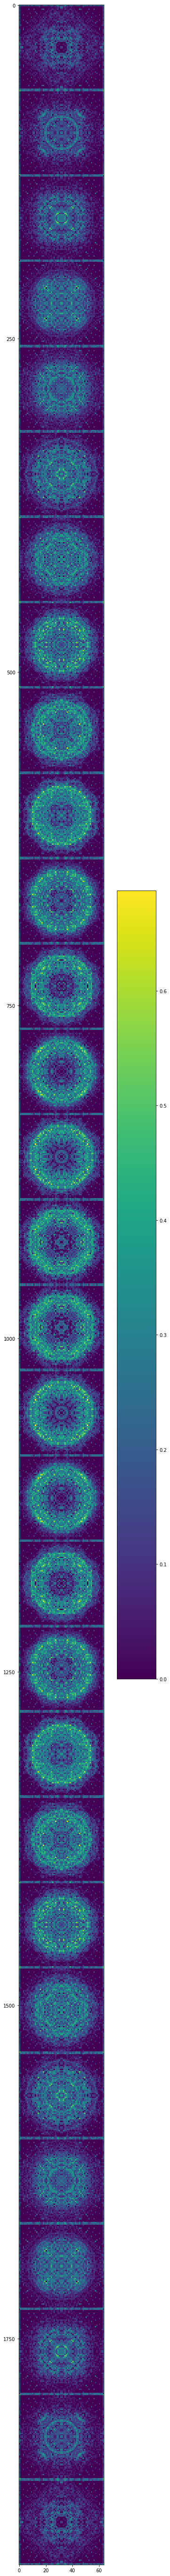

In [17]:
plt.figure(figsize=[10, 100])
#plt.imshow((dist_coll < 70) & (dist_coll > 50))
plt.imshow(dist_coll)
plt.colorbar()

In [18]:
dist_coll

array([[ 0.375 ,  0.1875,  0.1875, ...,  0.1875,  0.1875,  0.375 ],
       [ 0.1875,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.1875],
       [ 0.1875,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.1875],
       ..., 
       [ 0.1875,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.1875],
       [ 0.1875,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.1875],
       [ 0.375 ,  0.1875,  0.1875, ...,  0.1875,  0.1875,  0.375 ]])

In [19]:
!rm -r plots

In [20]:
!mkdir ./plots
!mkdir ./plots/mean_grads
!mkdir ./plots/percentage_distance
!mkdir ./plots/percentage_distance/smoothed
!mkdir ./plots/percentage_distance/raw
!mkdir ./plots/treshold_visualization
!mkdir ./plots/distance_metric/
!mkdir ./plots/distance_metric/voxel_tresholds
!mkdir ./plots/distance_metric/smoothed
!mkdir ./plots/distance_metric/raw
!mkdir ./plots/distance_metric/voxel_masks
!mkdir ./plots/clipped_metric/

In [21]:
def get_sorted_people():
    stat_list = []
    for i in range(len(all_people)):
        s = get_statistics_train(i)
        stat_list.append(-(s < .6).mean())
    return np.argsort(stat_list)

In [22]:
subject_rate = get_sorted_people()

In [23]:
for i in range(len(all_people)):
    plt.pcolormesh(t, f, np.abs(grad_list[i]).mean(0), vmin=0, cmap='plasma')
    plt.title("mean abs gradient input man {}".format(all_people[i][:-7]))
    plt.colorbar()
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.savefig('./plots/mean_grads/mean_gradient_subject_{}_rate_{}.png'.format(all_people[i][:-7], subject_rate[i]))
    plt.show()
    clear_output()

In [24]:
def plot_percentage_distance(man, threshold):
    stats = get_statistics_train(man)
    center_points = [14.5, 31.5, 31.5]
    scores = {}
    for i in range(30):
        for j in range(64):
            for k in range(64):
                dist = (120/30*(i - center_points[0]))**2 \
                + (210/64*(j - center_points[1]))**2\
                + (210/64*(k - center_points[2]))**2
                if dist not in scores:
                    scores[dist] = []
                scores[dist].append(stats[i, j, k] < threshold)

    for key in scores:
        scores[key] = np.mean(scores[key])

    keys, values = [], []
    for key in scores:
        keys.append(np.sqrt(key))
        values.append(scores[key])
    values = np.array(values)
    keys = np.array(keys)

    argsort = np.argsort(keys)

    plt.plot(keys[argsort], values[argsort])
    plt.title("Voxel percentage/Distance subject {} threshold {}".format(all_people[man][:-7], threshold))
    plt.ylabel('Voxel percentage')
    plt.xlabel('Distance [mm]')
    plt.savefig('./plots/percentage_distance/raw/percentage_distance_subject_{}_rate_{}.png'.format(all_people[man][:-7], subject_rate[man]))
    plt.show()

    plt.plot(keys[argsort], signal.savgol_filter(values[argsort], 53, 10))
    plt.title("Savgol Filter for voxel percentage/Distance subject {} threshold {}".format(all_people[man][:-7], threshold))
    plt.ylabel('Voxel percentage')
    plt.xlabel('Distance [mm]')
    
    plt.savefig('./plots/percentage_distance/smoothed/percentage_distance_subject_{}_rate_{}.png'.format(all_people[man][:-7], subject_rate[man]))
    plt.show()


In [25]:
def plot_tresholds(man):
    fmri_path = '../../data/fMRI/'
    fmri = read_img(os.path.join(fmri_path, str(all_people[man])))
    collage = np.concatenate([fmri.mean(-1)[..., i]/4095 for i in range(30)], axis = 0)
    stats = get_statistics_train(man)
    stats[stats > 2] = 2
    
    plt.figure(figsize=[20, 100])
    plt.subplot(171)
    plt.imshow(collage)
    plt.title('mean brain')
    plt.axis('off')
    #plt.suptitle('Treshold Visualisation subject {} rate {}'.format(all_people[man], subject_rate[man]), fontsize=1)
    for c, th in enumerate([.2, .4, .6, .8, 1]):
        plt.subplot(172 + c)
        collage_stats_tresh = np.concatenate([(stats[i]<th) for i in range(30)], axis = 0)
        plt.imshow(collage_stats_tresh)
        plt.title('treshold {}'.format(th))
        plt.axis('off')
    plt.savefig('./plots/treshold_visualization/Treshold Visualisation subject {} rate {}'.format(all_people[man][:-7], subject_rate[man]))
    plt.show()

In [26]:
for i in range(len(all_people)):
    plot_tresholds(i)
    clear_output()

In [27]:
for i in range(len(all_people)):
    plot_percentage_distance(i, 0.6)
    clear_output()

In [28]:
def plot_percentage_distance(man):
    fmri_path = '../../data/fMRI/'
    fmri = read_img(os.path.join(fmri_path, str(all_people[man])))
    mean_fmri = fmri.mean(-1)
    fmri_mask = mean_fmri > 66
    
    stats = get_statistics_train(man)
    center_points = [14.5, 31.5, 31.5]
    scores = {}
    for i in range(30):
        for j in range(64):
            for k in range(64):
                dist = (120/30*(i - center_points[0]))**2 \
                + (210/64*(j - center_points[1]))**2\
                + (210/64*(k - center_points[2]))**2
                
                
                if fmri_mask[j, k, i]:
                    if dist not in scores:
                        scores[dist] = []
                
                    scores[dist].append(stats[i, j, k])

    for key in scores:
        scores[key] = np.mean(scores[key])

    keys, values = [], []
    for key in scores:
        keys.append(np.sqrt(key))
        values.append(scores[key])
    values = np.array(values)
    keys = np.array(keys)

    argsort = np.argsort(keys)

    plt.plot(keys[argsort], values[argsort])
    plt.title("Voxel metric/Distance subject {}".format(all_people[man][:-7]))
    plt.ylabel('Voxel metric')
    plt.xlabel('Distance [mm]')
    plt.savefig('./plots/distance_metric/raw/metric_distance_subject_{}_rate_{}.png'.format(all_people[man][:-7], subject_rate[man]))
    plt.show()

    plt.plot(keys[argsort], signal.savgol_filter(values[argsort], 53, 10))
    plt.title("Savgol Filter for voxel metric/Distance subject {}".format(all_people[man][:-7]))
    plt.ylabel('Voxel metric')
    plt.xlabel('Distance [mm]')
    
    plt.savefig('./plots/distance_metric/smoothed/metric_distance_subject_{}_rate_{}.png'.format(all_people[man][:-7], subject_rate[man]))
    plt.show()



In [29]:
for i in range(len(all_people)):
    plot_percentage_distance(i)
    clear_output()

In [30]:
def plot_clipped_loss(man):
    stats = get_statistics_train(man)
    fig, axis = plt.subplots(6, 5, figsize=[40, 40])
    for slice_indx in range(30):
        img = stats[slice_indx]
        img[img > 2] = 2
        im = axis[slice_indx%6, slice_indx//6].imshow(img, cmap='plasma_r', vmin=0, vmax=2)
        plt.colorbar(im, ax=axis[slice_indx%6, slice_indx//6])
    plt.savefig('./plots/clipped_metric/clipped_metric_subject{}_rate_{}.png'.format(all_people[man][:-7], subject_rate[man]))
    plt.show()

In [31]:
def plot_filter_treshold(man):
    fmri_path = '../../data/fMRI/'
    fmri = read_img(os.path.join(fmri_path, str(all_people[man])))
    mean_fmri = fmri.mean(-1)

    th_list = np.linspace(0, mean_fmri.max(), 1000)
    acc_list = []
    for th in th_list:
        acc_list.append((mean_fmri > th).mean())
    acc_list = np.array(acc_list)
    #plt.figure(figsize=(20, 20))
    l = len(th_list[th_list < 66])
    plt.plot(th_list, acc_list, label='accepted voxels')
    plt.plot(th_list[:l], acc_list[:l], label='filtered voxels')
    plt.legend()
    plt.title("filtered voxels / tresholds subject {}".format(all_people[man]))
    plt.ylabel("voxel persentage")
    plt.xlabel("tresholds")
    plt.savefig('./plots/distance_metric/voxel_tresholds/voxel_persentage_subject{}_rate_{}.png'.format(all_people[man][:-7], subject_rate[man]))
    plt.show()

In [32]:
def plot_mask(man):
    fmri_path = '../../data/fMRI/'
    fmri = read_img(os.path.join(fmri_path, str(all_people[man])))
    mean_fmri = fmri.mean(-1)
    fmri_mask = mean_fmri > 66
    
    collage = np.concatenate([fmri.mean(-1)[..., i]/4095 for i in range(30)], axis = 0)
    collage_mask = np.concatenate([fmri_mask[..., i] for i in range(30)], axis = 0)
    
    plt.figure(figsize=[20, 200])
    plt.subplot(121)
    plt.imshow(collage)
    plt.title('mean brain')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(collage_mask)
    plt.title('mask')
    plt.axis('off')
    plt.savefig('./plots/distance_metric/voxel_masks/mask_subject{}_rate_{}.png'.format(all_people[man][:-7], subject_rate[man]))
    plt.show()

In [33]:
center_points = [14.5, 31.5, 31.5]
distances = np.zeros([30, 64, 64])
for i in range(30):
    for j in range(64):
        for k in range(64):
            dist = (120/30*(i - center_points[0]))**2 \
            + (210/64*(j - center_points[1]))**2\
            + (210/64*(k - center_points[2]))**2
            distances[i, j, k] = dist

            

In [34]:
for i in range(len(all_people)):
    plot_clipped_loss(i)
    clear_output()

In [35]:
for i in range(len(all_people)):
    plot_mask(i)
    clear_output()

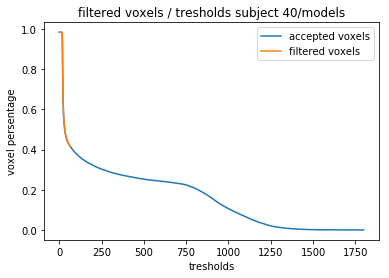

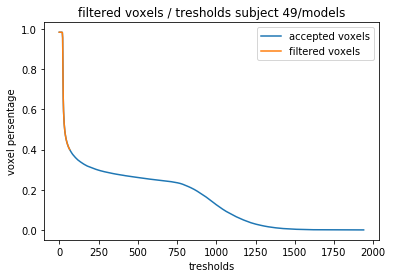

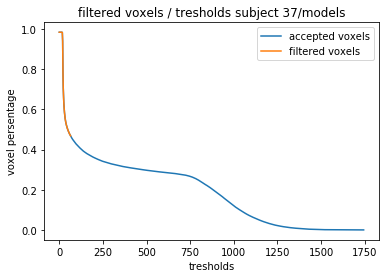

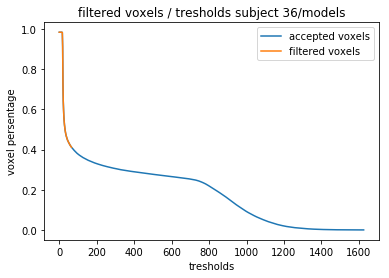

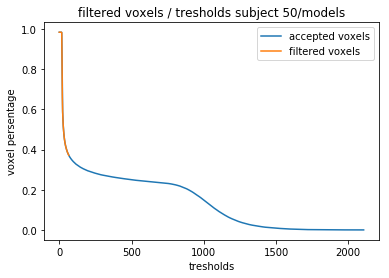

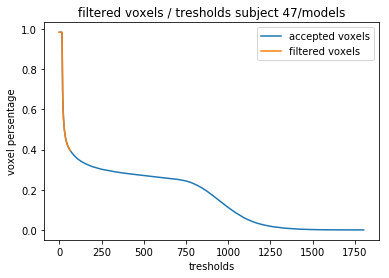

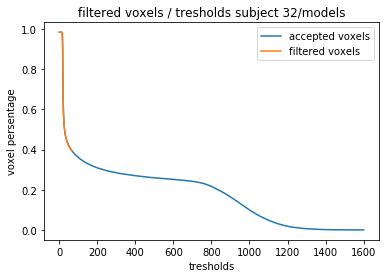

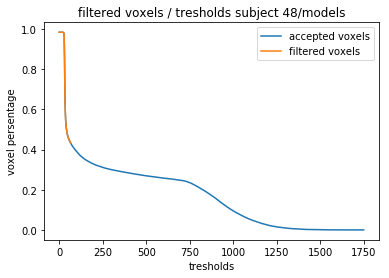

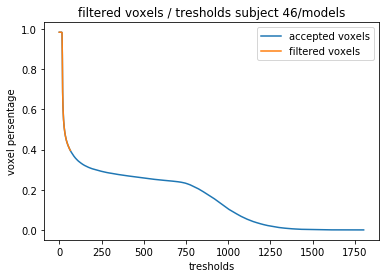

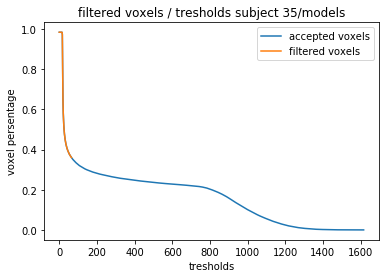

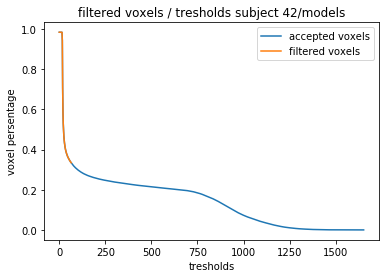

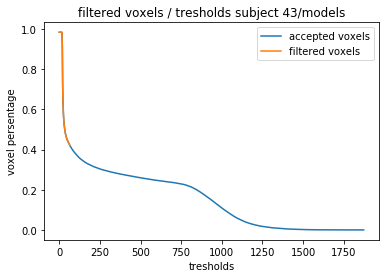

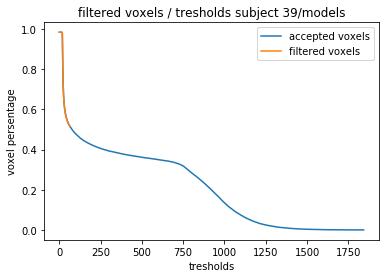

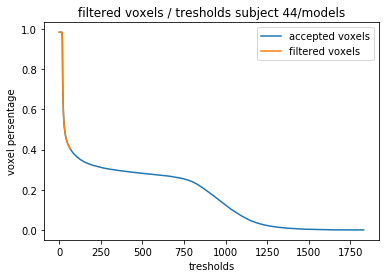

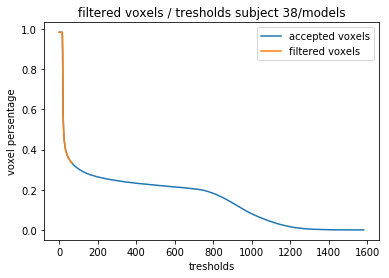

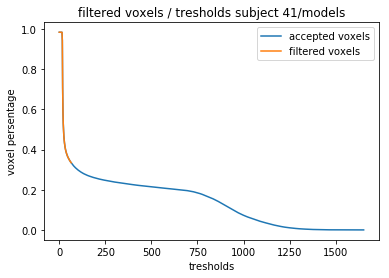

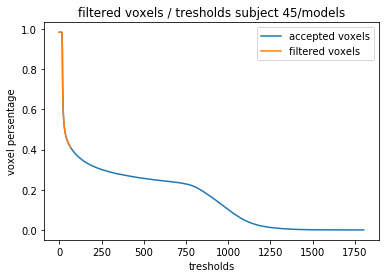

In [36]:
for i in range(len(all_people)):
    plot_filter_treshold(i)

In [37]:
!tar -cvf plots3d_1.tar ./plots

./plots/
./plots/clipped_metric/
./plots/clipped_metric/clipped_metric_subject45_rate_10.png
./plots/clipped_metric/clipped_metric_subject35_rate_2.png
./plots/clipped_metric/clipped_metric_subject41_rate_14.png
./plots/clipped_metric/clipped_metric_subject40_rate_11.png
./plots/clipped_metric/clipped_metric_subject42_rate_13.png
./plots/clipped_metric/clipped_metric_subject46_rate_8.png
./plots/clipped_metric/clipped_metric_subject44_rate_5.png
./plots/clipped_metric/clipped_metric_subject32_rate_4.png
./plots/clipped_metric/clipped_metric_subject43_rate_3.png
./plots/clipped_metric/clipped_metric_subject47_rate_9.png
./plots/clipped_metric/clipped_metric_subject39_rate_6.png
./plots/clipped_metric/clipped_metric_subject48_rate_0.png
./plots/clipped_metric/clipped_metric_subject38_rate_7.png
./plots/clipped_metric/clipped_metric_subject50_rate_12.png
./plots/clipped_metric/clipped_metric_subject37_rate_1.png
./plots/clipped_metric/clipped_metric_subject36_rate_15.png
./plots/clipped_m

In [260]:
th_list[acc_list > 0.4][-1]

65.985298631965293

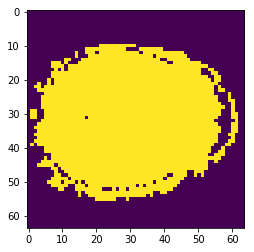

In [263]:
plt.imshow((mean_fmri > 100)[...,10])

In [256]:
th_list

array([    0.        ,     1.745996  ,     3.49199199,     5.23798799,
           6.98398398,     8.72997998,    10.47597598,    12.22197197,
          13.96796797,    15.71396396,    17.45995996,    19.20595596,
          20.95195195,    22.69794795,    24.44394394,    26.18993994,
          27.93593594,    29.68193193,    31.42792793,    33.17392392,
          34.91991992,    36.66591592,    38.41191191,    40.15790791,
          41.9039039 ,    43.6498999 ,    45.3958959 ,    47.14189189,
          48.88788789,    50.63388388,    52.37987988,    54.12587588,
          55.87187187,    57.61786787,    59.36386386,    61.10985986,
          62.85585586,    64.60185185,    66.34784785,    68.09384384,
          69.83983984,    71.58583584,    73.33183183,    75.07782783,
          76.82382382,    78.56981982,    80.31581582,    82.06181181,
          83.80780781,    85.5538038 ,    87.2997998 ,    89.0457958 ,
          90.79179179,    92.53778779,    94.28378378,    96.02977978,
      

In [223]:
acc_list

[0.0,
 0.015625,
 0.015625,
 0.015625,
 0.015625,
 0.015625,
 0.015625,
 0.015625,
 0.015625,
 0.016007486979166666,
 0.040771484375,
 0.20861002604166667,
 0.32752278645833333,
 0.38725585937500001,
 0.4254150390625,
 0.45231119791666669,
 0.47246907552083334,
 0.48842773437499998,
 0.50153808593750004,
 0.51244303385416667,
 0.5219401041666667,
 0.5295084635416667,
 0.53627929687499998,
 0.54242350260416672,
 0.54764811197916663,
 0.55219726562500004,
 0.55615234375,
 0.5598470052083333,
 0.56315104166666663,
 0.56645507812499996,
 0.56914062499999996,
 0.57200520833333335,
 0.5747395833333333,
 0.57719726562499996,
 0.57949218749999998,
 0.58186848958333337,
 0.58388671874999998,
 0.58616536458333335,
 0.58838704427083333,
 0.59055175781250002,
 0.59282226562499996,
 0.59494628906250002,
 0.59693196614583333,
 0.59895833333333337,
 0.60109049479166665,
 0.6030598958333333,
 0.60476074218749998,
 0.60655110677083335,
 0.60841471354166665,
 0.61013183593749998,
 0.61189778645833337,
 

In [27]:
stats = get_statistics_train(1)

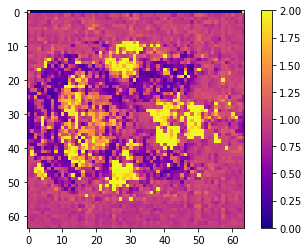

In [34]:
plt.imshow(stats[0], cmap='plasma', vmax=2)
plt.colorbar()

In [ ]:
plt.imshow(stats[0], cmap='plasma', vmax=2)
plt.colorbar()

In [35]:
fmri_path = '../../data/fMRI/'
fmri = read_img(os.path.join(fmri_path, str(all_people[0])))

In [36]:
from mpl_toolkits.mplot3d import Axes3D

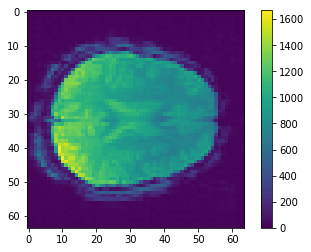

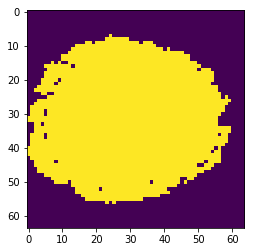

In [57]:
plt.imshow(fmri.mean(-1)[..., 15])
plt.colorbar()
plt.show()
plt.imshow(fmri.mean(-1)[..., 15] > 70)

In [150]:
man = 0

fmri_path = '../../data/fMRI/'
fmri = read_img(os.path.join(fmri_path, str(all_people[man])))

collage = np.concatenate([fmri.mean(-1)[..., i]/4095 for i in range(30)], axis = 0)

stats = get_statistics_train(man)

stats[stats > 2] = 2

collage_stats = np.concatenate([(1 - (stats[i]/2)) for i in range(30)], axis = 0)
collage_stats_tresh2 = np.concatenate([(stats[i]<.2) for i in range(30)], axis = 0)
collage_stats_tresh4 = np.concatenate([(stats[i]<.4) for i in range(30)], axis = 0)
collage_stats_tresh6 = np.concatenate([(stats[i]<.6) for i in range(30)], axis = 0)
collage_stats_tresh8 = np.concatenate([(stats[i]<.8) for i in range(30)], axis = 0)
collage_stats_tresh1 = np.concatenate([(stats[i]<1) for i in range(30)], axis = 0)

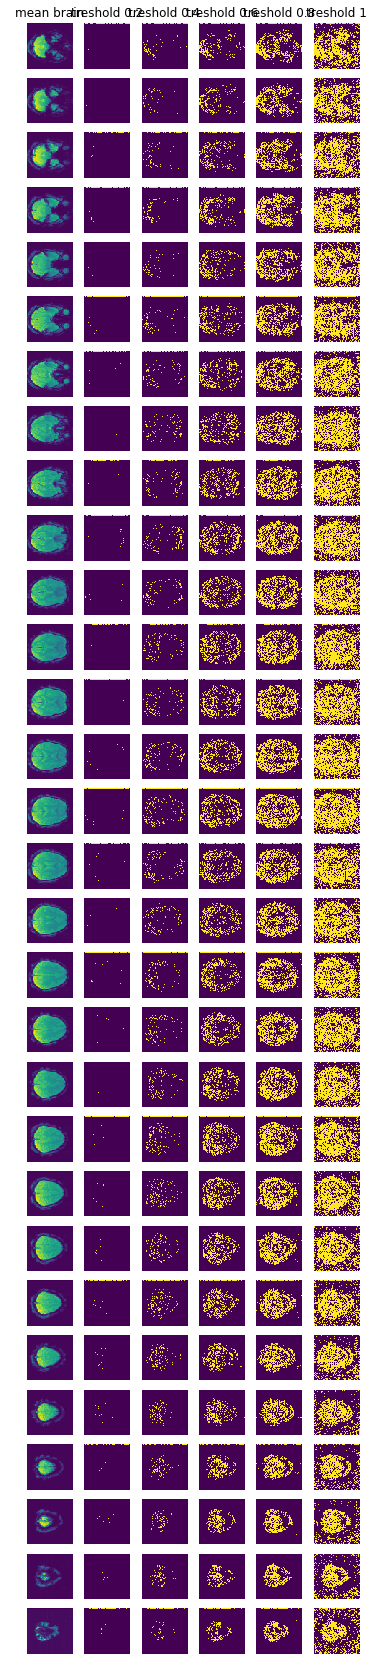

In [208]:
plt.figure(figsize=[6, 30])
for i in range(30):
    plt.subplot(30, 6, i*6+1)
    plt.imshow(fmri.mean(-1)[..., i]/4095)
    plt.axis('off')
    if i == 0:
        plt.title('mean brain')


#plt.suptitle('Treshold Visualisation subject {} rate {}'.format(all_people[man], subject_rate[man]), fontsize=1)
for c, th in enumerate([.2, .4, .6, .8, 1]):
    for i in range(30):
        plt.subplot(30, 6, i*6 + c + 2)
        #collage_stats_tresh = np.concatenate([(stats[i]<th) for i in range(30)], axis = 0)
        plt.imshow(stats[i]<th)
        plt.axis('off')
        if i == 0:
            plt.title('treshold {}'.format(th))
    
plt.savefig('lol.png')
plt.show()
    

In [96]:
collage_stats = np.concatenate([stats[i] for i in range(30)], axis = 0)

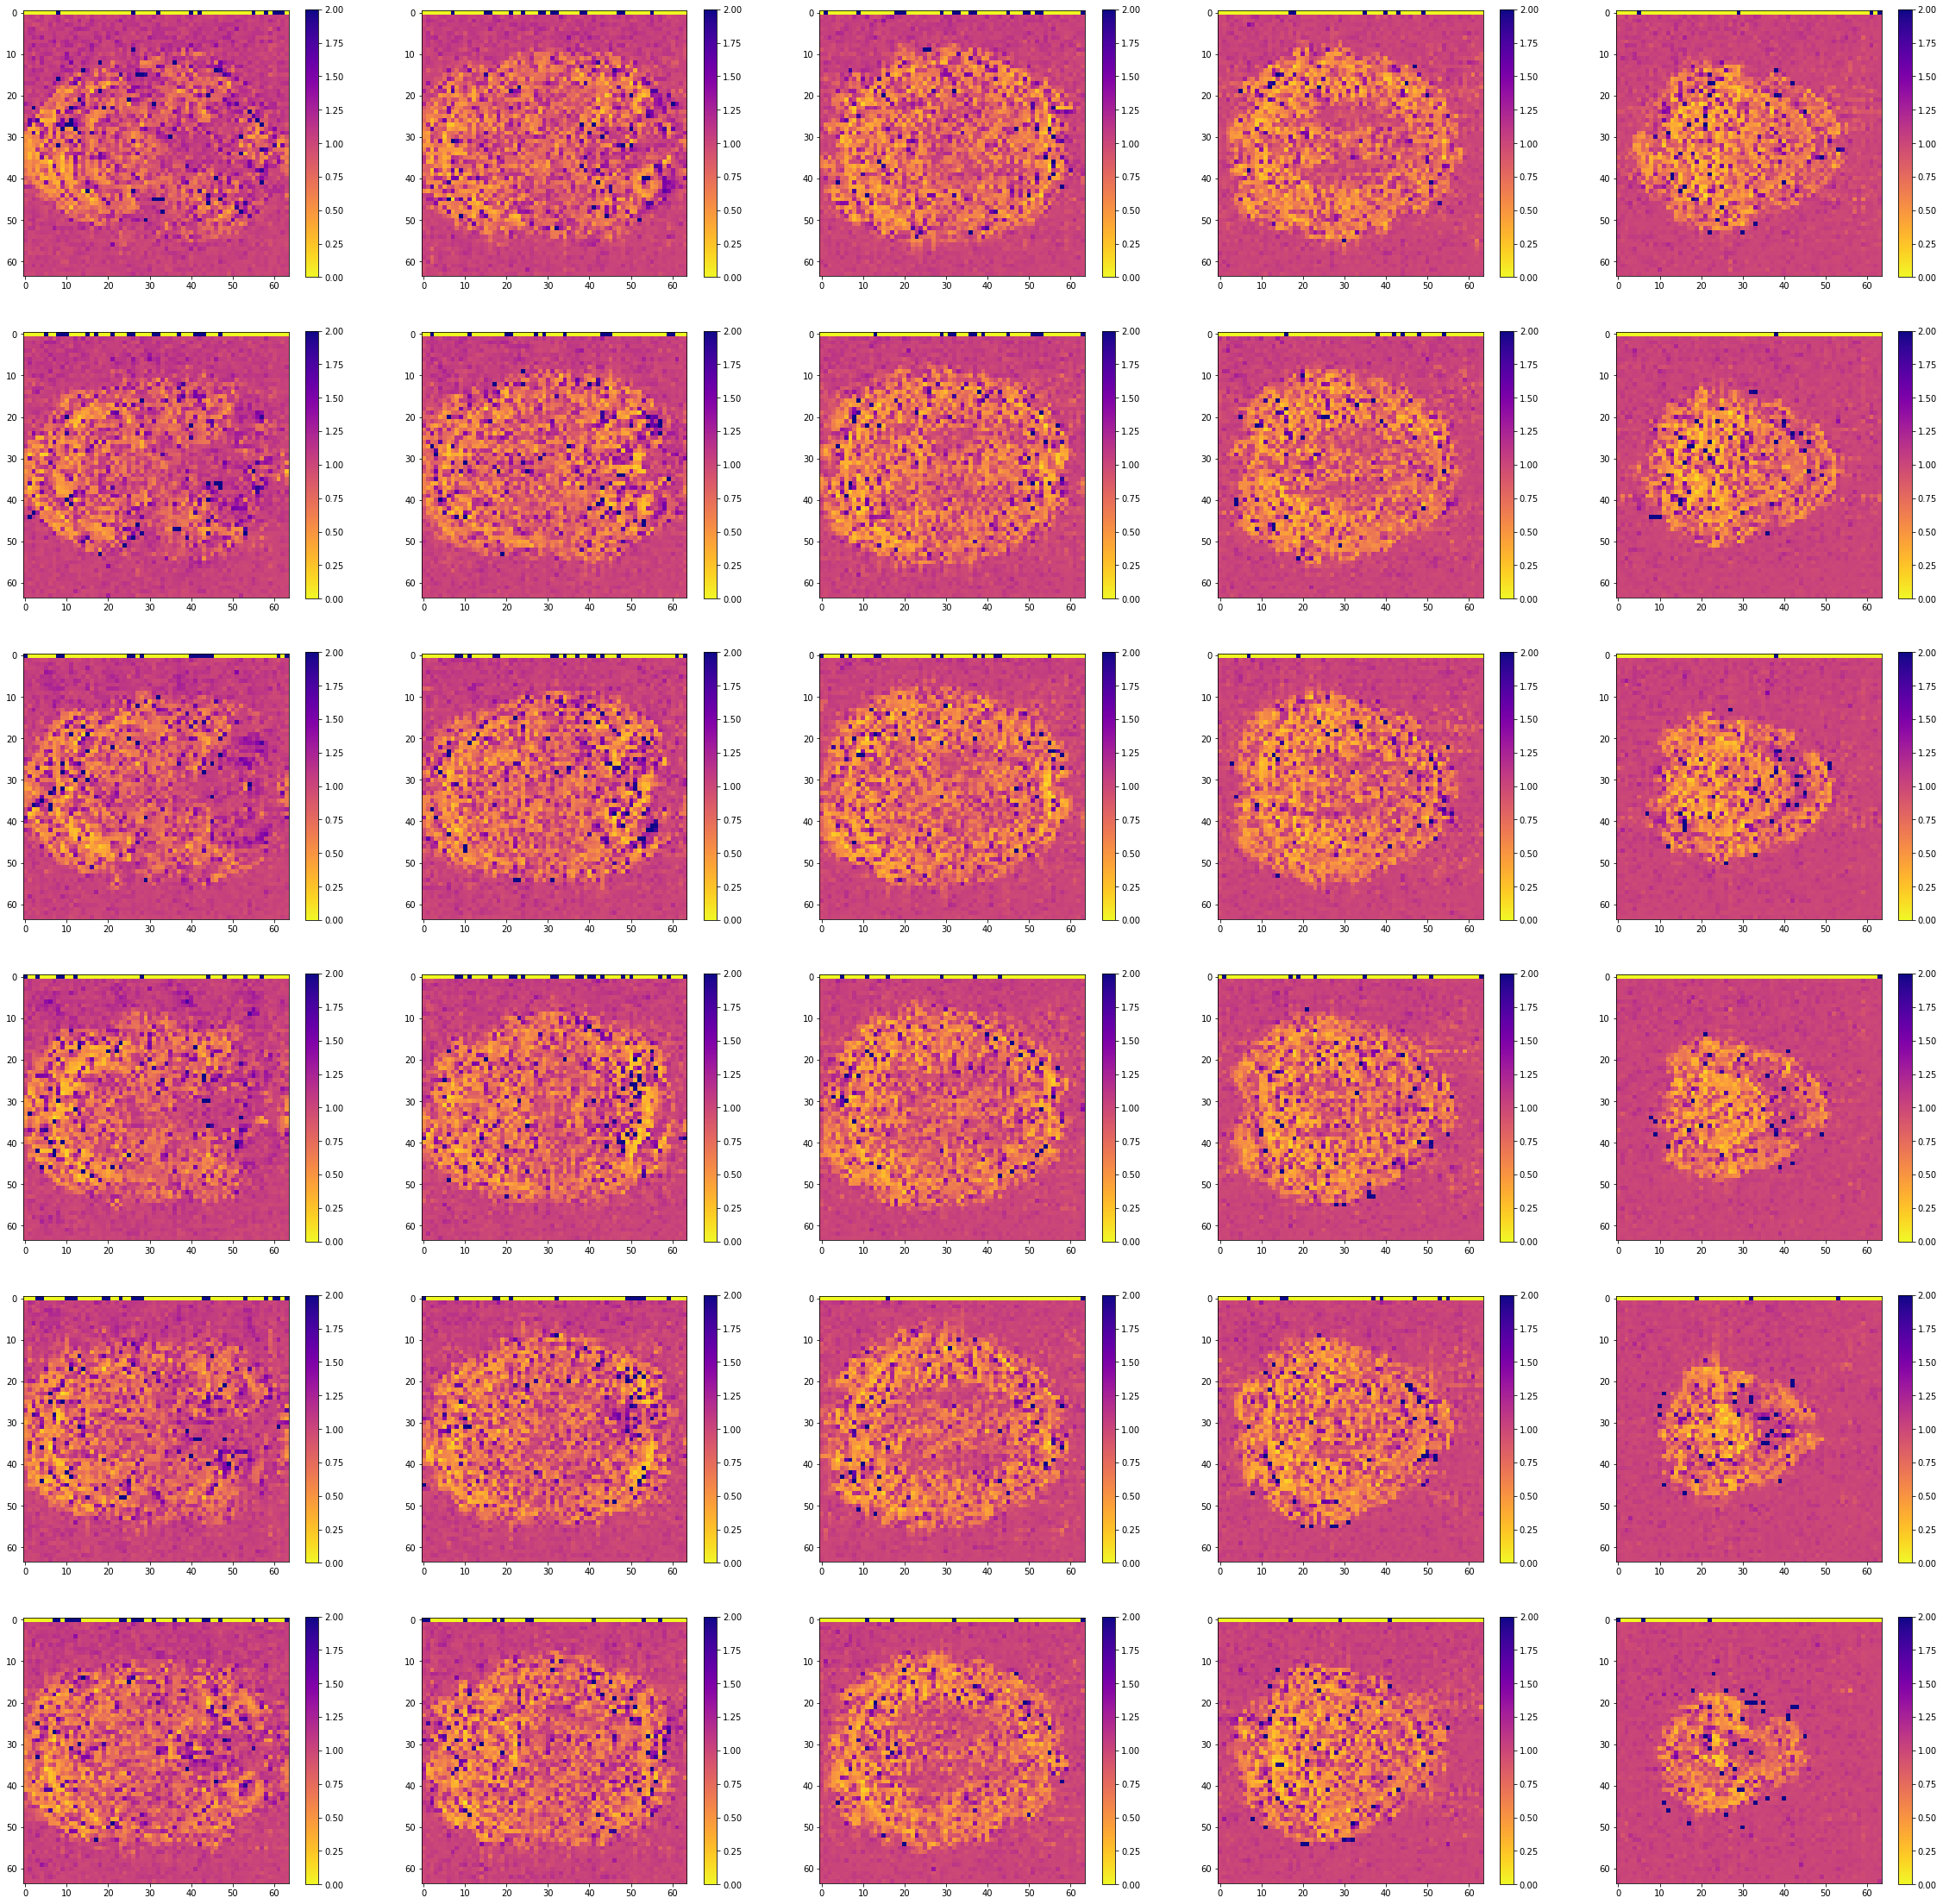

In [100]:
stats = get_statistics_train(0)
fig, axis = plt.subplots(6, 5, figsize=[40, 40])
for slice_indx in range(30):
    img = stats[slice_indx]
    img[img > 2] = 2
    im = axis[slice_indx%6, slice_indx//6].imshow(img, cmap='plasma_r', vmin=0, vmax=2)
    plt.colorbar(im, ax=axis[slice_indx%6, slice_indx//6])

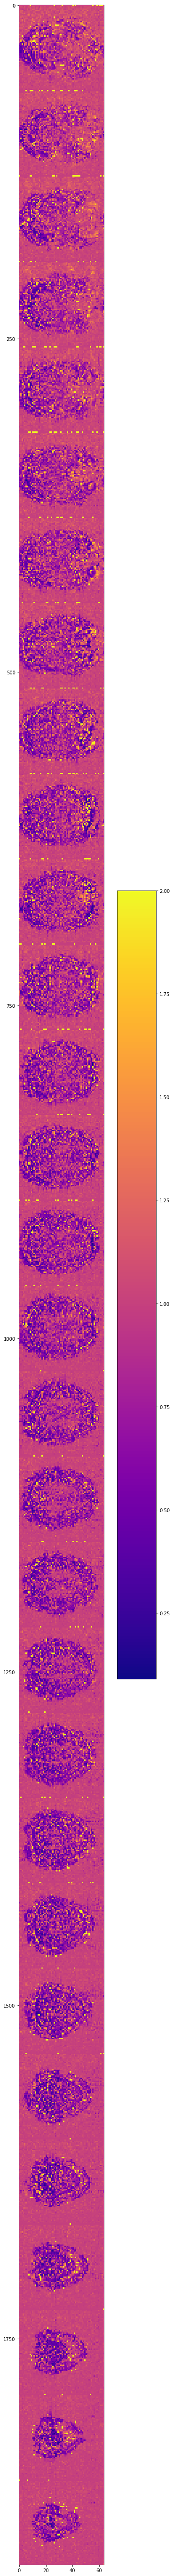

In [97]:
plt.figure(figsize=[10, 100])
collage_stats[collage_stats == 0] = 1
collage_stats[collage_stats > 2] = 2
plt.imshow(collage_stats, cmap='plasma')
plt.colorbar()

In [ ]:
fig, axis = plt.subplots(6, 5, figsize=[40, 40])
for slice_indx in range(30):
    img = r2_list[:,slice_indx].mean(0)
    im = axis[slice_indx%6, slice_indx//6].imshow(img, cmap='plasma', vmin=0, vmax=1)
    plt.colorbar(im, ax=axis[slice_indx%6, slice_indx//6])

In [353]:
collage_stats.max()

36927.011059403558

In [13]:
collage = np.concatenate([fmri.mean(-1)[..., i]/4095 for i in range(30)], axis = 0)

stats = get_statistics_train(1)

stats[stats > 2] = 2

collage_stats = np.concatenate([(1 - (stats[i]/2)) for i in range(30)], axis = 0)
collage_stats_tresh2 = np.concatenate([(stats[i]<.2) for i in range(30)], axis = 0)
collage_stats_tresh4 = np.concatenate([(stats[i]<.4) for i in range(30)], axis = 0)
collage_stats_tresh6 = np.concatenate([(stats[i]<.6) for i in range(30)], axis = 0)
collage_stats_tresh8 = np.concatenate([(stats[i]<.8) for i in range(30)], axis = 0)
collage_stats_tresh1 = np.concatenate([(stats[i]<1) for i in range(30)], axis = 0)

collage = np.concatenate([collage, collage_stats, collage_stats_tresh2, collage_stats_tresh4,collage_stats_tresh6, collage_stats_tresh8, collage_stats_tresh1], axis = 1)
io.imsave('coll_49_train_mean.png', collage)

NameError: name 'fmri' is not defined

In [112]:
def _plot_r2(r2_list):
    fig, axis = plt.subplots(6, 5, figsize=[40, 40])
    for slice_indx in range(30):
        img = r2_list[:,slice_indx].mean(0)
        im = axis[slice_indx%6, slice_indx//6].imshow(img, cmap='plasma', vmin=0, vmax=1)
        plt.colorbar(im, ax=axis[slice_indx%6, slice_indx//6])

def plot_r2(men_list=all_people):
    sll = []
    sbll = []
    for man in men_list:
        sll.append(slice_losses_list[all_people_dict[man]])
        sbll.append(slice_total_squares_list[all_people_dict[man]])
    sll = np.array(sll)
    sbll = np.array(sbll)
    _plot_r2(1-sll/(sbll+1e-7))
    
def plot_correlations(men_list=all_people):
    res = []
    for man in men_list:
        res.append(get_correlations(man))
    res = sum(res)/len(res)
    fig, axis = plt.subplots(6, 5, figsize=[40, 40])
    for slice_indx in range(30):
        img = res[slice_indx]
        im = axis[slice_indx%6, slice_indx//6].imshow(img, cmap='plasma', vmin=-1, vmax=1)
        plt.colorbar(im, ax=axis[slice_indx%6, slice_indx//6])
        
def plot_voxel_predictions(man, slice, indx1, indx2):
    net, gt = get_voxel_predictions(man, slice, indx1, indx2)
    plt.plot(net, label='net')
    plt.plot(gt, label='ground truth')
    plt.legend()
    plt.show()
    
def plot_grad(men_list=all_people):
    grad_list = [get_grad(man) for man in men_list]
    grad_list = sum(grad_list) / len(grad_list)
    fig, axis = plt.subplots(16, 4, figsize=[40, 160])
    for slice_indx in range(64):
        img = grad_list[slice_indx]
        im = axis[slice_indx%16, slice_indx//16].imshow(img, cmap='plasma', vmin=0, vmax=np.max(grad_list))
        plt.colorbar(im, ax=axis[slice_indx%16, slice_indx//16])

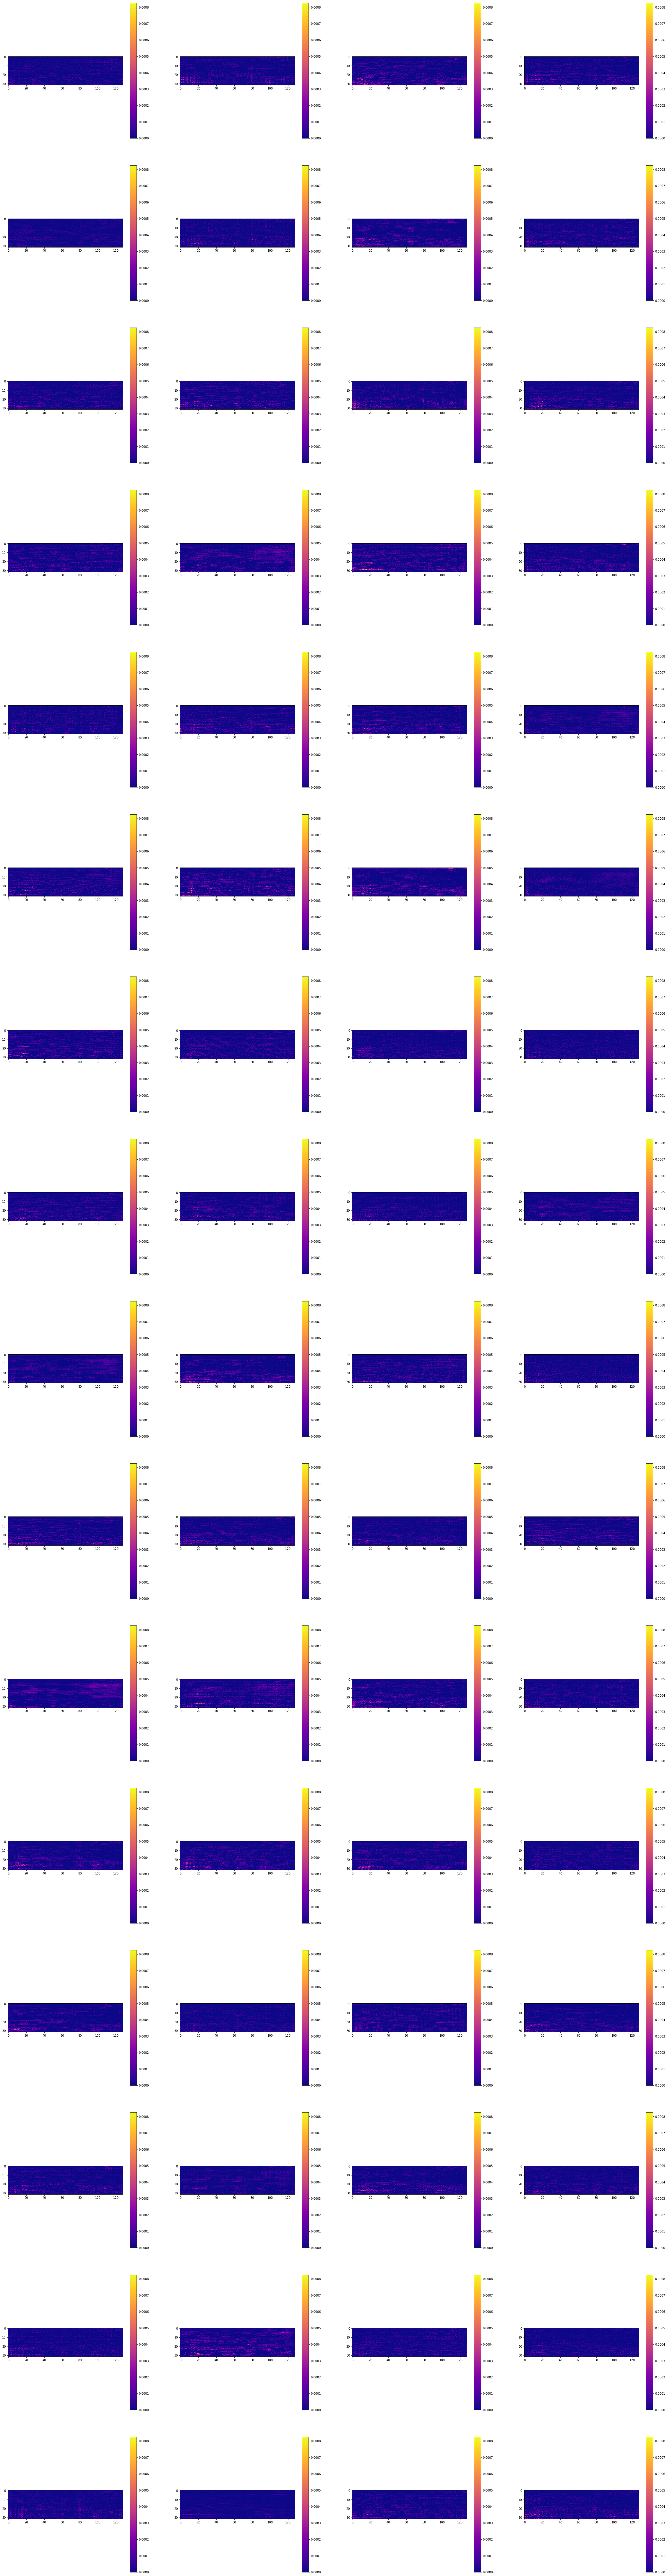

In [256]:
plot_grad(['37/models'])

In [232]:
stats = get_statistics_full(0)

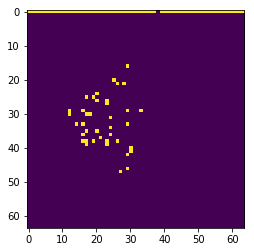

In [245]:
plt.imshow(stats[-4] < .4)

In [239]:
(stats[ 2:] < .4).sum()

2346

In [158]:
print(stats[10, 25, 53:] < .3)

[ True  True False False False False False False False False False]


In [253]:
stats[26, 39,23:] < .4

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False], dtype=bool)

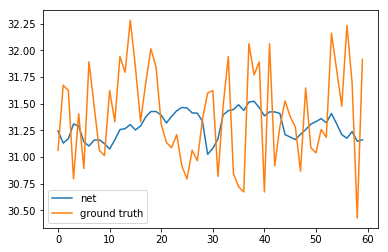

In [254]:
plot_voxel_predictions('40/models', 26, 39, 23)

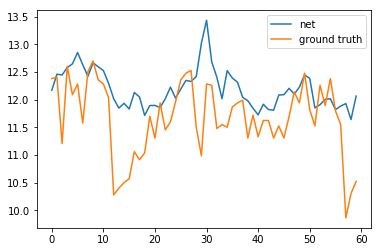

In [160]:
plot_voxel_predictions('40/models', 10, 25, 53)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


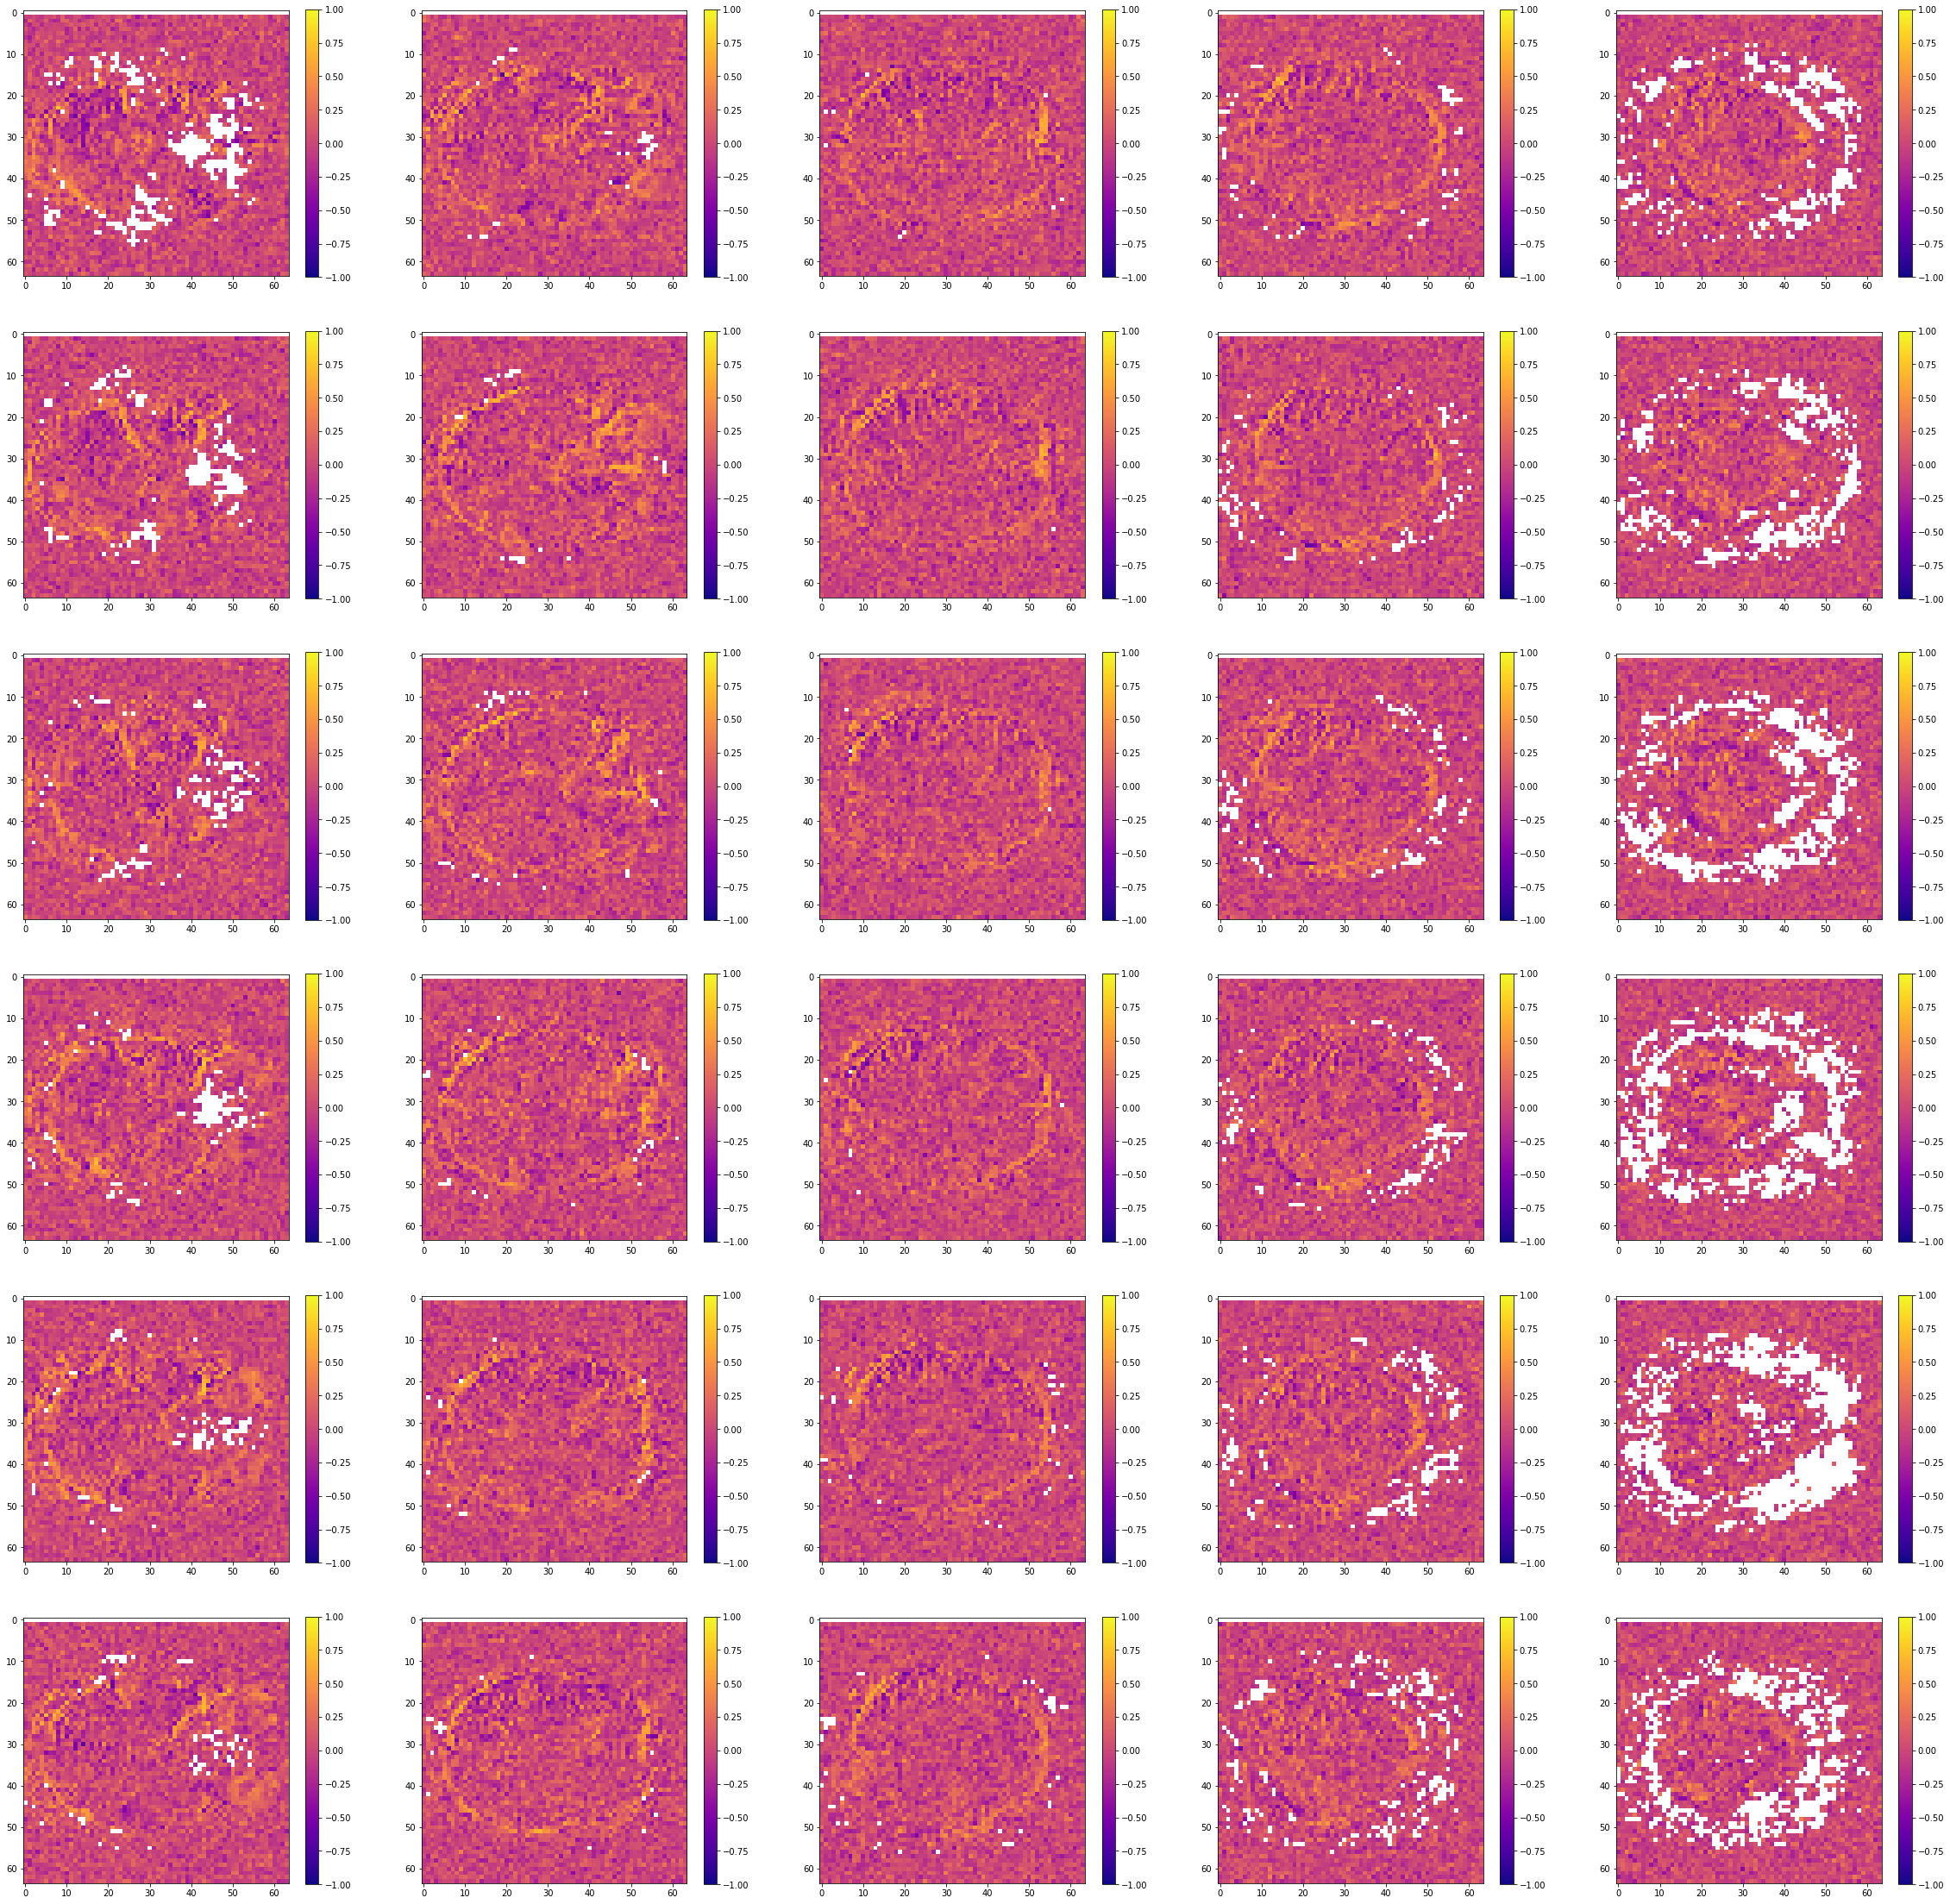

In [17]:
plot_correlations([40])

In [82]:
fmrt = read_img(os.path.join(fmri_path, str(all_people[i])))

/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


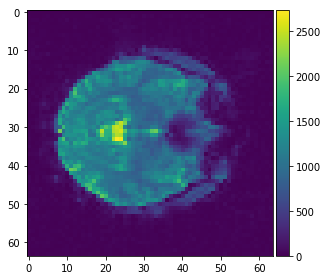

In [86]:
io.imshow(fmrt[..., 10, 0])

In [83]:
fmrt.shape

(64, 64, 30, 300)

In [257]:
all_people

['40/models', '49/models', '37/models', '42/models']

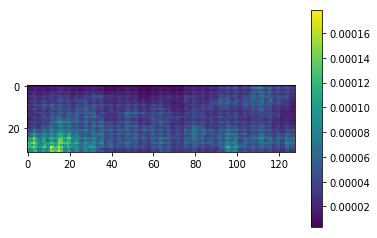

In [267]:
plt.imshow(np.abs(grad_list[-2]).mean(0))
plt.colorbar()

In [260]:
grad_list[-2].shape

(64, 32, 128)

In [265]:
np.abs(grad_list[i]).mean(0).min()

1.2874793e-05

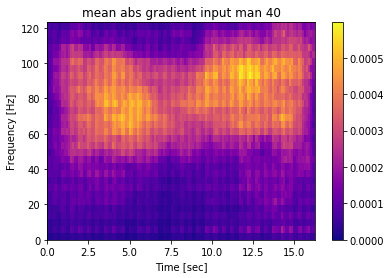

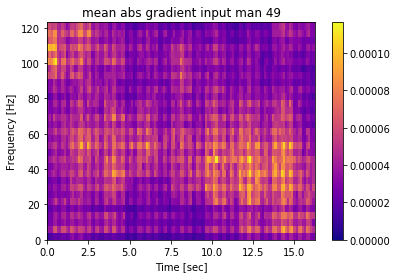

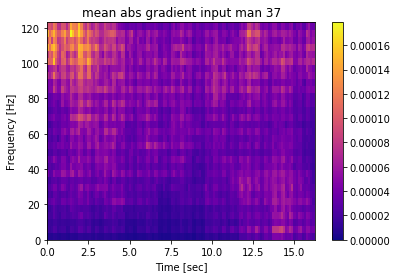

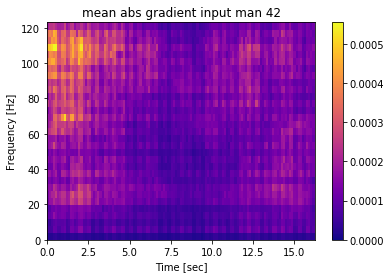

In [263]:
for i in range(len(all_people)):
    plt.pcolormesh(t, f, np.abs(grad_list[i]).mean(0), vmin=0, cmap='plasma')
    plt.title("mean abs gradient input man {}".format(all_people[i][:-7]))
    plt.colorbar()
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    #plt.savefig('./plots/mean_grads/mean_gradient_subject_{}_rate_{}.png'.format(all_people[i][:-7], subject_rate[i]))
    plt.show()
    #clear_output()